<div class="row">
  <div class="column">
    <img src="./img/logo-onera.png" width="200">
  </div>
  <div class="column">
    <img src="./img/logo-ISAE_SUPAERO.png" width="200">
  </div>
</div>

# Using FAST-OAD for the sizing and study of the aircraft

This notebooks aims to show you how FAST-OAD can be used to analyse the design of an aircraft and its performance on other mission than the design one. It will also aims to start a reflection on the performance difference between an aircraft used on a shorter mission and an aircraft used on its design mission.

***
***
## Imports

In [22]:
import os.path as pth
import sys
import logging
import shutil
import warnings

warnings.filterwarnings(action='ignore')

import openmdao.api as om

import fastoad.api as oad

sys.path.append(pth.abspath("."))

## Working directories and reference files 
Here you can define your working directory and data storage folder as well as reference files names. 

In [23]:
logging.basicConfig(level=logging.INFO, format="%(levelname)-8s: %(message)s")

DATA_FOLDER_PATH = "data"

WORK_FOLDER_PATH = "workdir"

SOURCE_FILE = pth.join(DATA_FOLDER_PATH, "Aircraft_reference_data.xml")

## Sizing of the aircraft

For the first part of this notebook, you will need to verify the sizing of your aircraft using FAST-OAD. To do so we will use a different way to compute the mission that the one used in the tutorials. In the tutorial, a simple Breguet formula was used, here we will use the mission file (It was possible to use it in the first tutorial, a comment made mention of it). This file allows you to describe segment after segment the mission you want your aircraft to fly. 

### 1.1. The mission file

You will use the mission module to compute the fuel consumption over a specified mission. Therefore, you need to define the different phases your mission is composed of. That operation is done through the YAML [mission file](./data/design_mission.yml). If you have a closer look to this file, you will notice that it starts with a definition of the different flight phases (initial climb, climb, descent, holding, taxi) for which one or several flight parameter(s) is (are) varying.

For exemple, for the initial climb phase, the first segment is performed at iso-speed with a variation of altitude up to 400ft, then a second segment defines an acceleration at iso-altitude up to 250kt and a third segment at iso-speed and targetting an altitude of 15000ft completes this phase.

Each phases are then organised and completed with a cruise phase to form a route. Several routes can then be combined to form a mission profile. 

Each mission profile should have a unique name.

For further information about the mission definition, please see the [official documentation](https://fast-oad.readthedocs.io/en/documentation/mission_module/index.html).

### 1.2. The configuration file

As already mentioned, the [configuration file](./data/oad_sizing.yml) you are using enables you run the full OAD sizing process. Here a particular attention is paid on the performance module definition. 

First, in this section, you will call the [mission file](./data/design_mission.yml) you want to use through the `mission_file_path` option. You will then indicate which mission profile to select accordingly to the naming convention you chose in the mission file. This is done using the `mission_name` option. In the present situation you will compute performances for the mission called `MTOW_mission`. 

Note also that the option `is_sizing` of the performance group is active. That means that the mission TOW computed by the performance module is considered as the design Maximum Take-Off Weight and will impact the aircraft design. 

You can also notice that the option `add_solver` is deactivated as solvers are already defined for the whole problem in the [configuration file](./data/oad_sizing.yml).

In [24]:
OAD_CONFIGURATION_FILE = pth.join(DATA_FOLDER_PATH, "oad_sizing.yml")

### 1.3. The input file
You can now generate the input file and fill out the values that corresponds to your aircraft. If you look into the file you will see that some of the value have already been filled by the default values, you will need to change those to match the value of the aircraft. First, let's generate this input file.

In [25]:
INPUT_FILE = oad.generate_inputs(OAD_CONFIGURATION_FILE, SOURCE_FILE, overwrite=True)

oad.variable_viewer(INPUT_FILE)

INFO    : Problem inputs written in c:\Users\robbe\Documents\GitHub\Aircraft-Design-2A\B_Aircraft Sizing and Performances\workdir\oad_sizing_in.xml


Some of them might not be known, you can keep the default value for them. However, you need to fill out the values in the following cell so that the process does not take the default value rather than the one that correspond to your aircraft. <code style="background:yellow;color:black">To find in which unit you must fill your values, we have listed the problem variables in the cell above</code>. There might be some adjustement to make to find the right values on some parameters. For instance the thickness-to-chord ratio is omputed in FAST-OAD using a formula base on the cruise mach and wing sweep angle. This formula however uses empirical coefficient which depends a lot on the airfoil technology so it might be wrong for new and/or old aircraft. The cruise mach being an important design parameters, the sweep angle could be changed a little in this case.

In [28]:
input_file = oad.DataFile(INPUT_FILE)

# TLARs
input_file["data:TLAR:NPAX"].value = 291
input_file["data:TLAR:approach_speed"].value = 67.097
input_file["data:TLAR:cruise_mach"].value = 0.81
input_file["data:TLAR:range"].value = 5760

# Geometry
input_file["data:geometry:cabin:aisle_width"].value = 0.508
input_file["data:geometry:cabin:seats:economical:count_by_row"].value = 7
input_file["data:geometry:cabin:seats:economical:length"].value = 0.812
input_file["data:geometry:cabin:seats:economical:width"].value = 0.533

input_file["data:geometry:flap:chord_ratio"].value =0.197
input_file["data:geometry:flap:span_ratio"].value = 0.8

input_file["data:geometry:horizontal_tail:aspect_ratio"].value = 4.46
input_file["data:geometry:horizontal_tail:sweep_25"].value = 32
input_file["data:geometry:horizontal_tail:taper_ratio"].value = 0.2
input_file["data:geometry:horizontal_tail:thickness_ratio"].value = 0.1

input_file["data:geometry:propulsion:engine:y_ratio"].value = 0.34

input_file["data:geometry:vertical_tail:aspect_ratio"].value = 1.76
input_file["data:geometry:vertical_tail:sweep_25"].value =39
input_file["data:geometry:vertical_tail:taper_ratio"].value = 0.31
input_file["data:geometry:vertical_tail:thickness_ratio"].value = 0.11

input_file["data:geometry:wing:aspect_ratio"].value = 7.99
input_file["data:geometry:wing:sweep_25"].value =29.5
input_file["data:geometry:wing:kink:span_ratio"].value =0.375
input_file["data:geometry:wing:virtual_taper_ratio"].value = 0.315# Put arround 1.5 * the actual wing taper ratio
input_file["data:geometry:wing:MAC:at25percent:x"].value = 25.13

# Propulsion
input_file["data:propulsion:MTO_thrust"].value = 270000

input_file["data:propulsion:rubber_engine:design_altitude"].value = 10058.4
input_file["data:propulsion:rubber_engine:maximum_mach"].value =0.81
input_file["data:propulsion:rubber_engine:overall_pressure_ratio"].value =32.6

# Weight
input_file["data:weight:aircraft:max_payload"].value = 45541
input_file["data:weight:aircraft:payload"].value = 20520

# Mission
input_file["data:mission:MTOW_mission:diversion:distance"].value = 200
input_file["data:mission:MTOW_mission:holding:duration"].value = 30
input_file["data:mission:MTOW_mission:main_route:range"].value = 5780
input_file["data:mission:MTOW_mission:takeoff:V2"].value = 82.3
input_file["data:mission:MTOW_mission:takeoff:fuel"].value = 82.4

input_file["data:mission:sizing:takeoff:flap_angle"].value = 10
input_file["data:mission:sizing:takeoff:slat_angle"].value = 22
input_file["data:mission:sizing:landing:flap_angle"].value = 40
input_file["data:mission:sizing:landing:slat_angle"].value = 22
input_file["data:mission:sizing:main_route:cruise:altitude"].value = 34000

# The motor model is very sensitive to the input, this is the reason why there might be a great over- or under-estimation of 
# the sfc in cruise. For this reason we propose to first run the aircraft without any tuning and to then adjust the sfc based 
# on the results of the first run. You can change the following value after your first run:

input_file["tuning:propulsion:rubber_engine:SFC:k_cr"].value = 0.80681

input_file.save()

You can check that the inputs are correctly written by using the following command:

In [29]:
oad.variable_viewer(INPUT_FILE)

### 1.4. Run the OAD process

Now, run the problem and check the output file:

In [30]:
MTOW_problem = oad.evaluate_problem(OAD_CONFIGURATION_FILE, overwrite=True)

INFO    : Mission computation - iteration 0 : Using initializer computation. OTHER ITERATIONS NEEDED.
INFO    : Mission computation - iteration 1 : Using mission definition.
INFO    : Mission computation - iteration 2 : Using mission definition.
INFO    : Mission computation - iteration 3 : Using mission definition.
INFO    : Mission computation - iteration 4 : Using mission definition.
INFO    : Mission computation - iteration 5 : Using mission definition.
INFO    : Mission computation - iteration 6 : Using mission definition.
INFO    : Mission computation - iteration 7 : Using mission definition.
INFO    : Mission computation - iteration 8 : Using mission definition.
INFO    : Mission computation - iteration 9 : Using mission definition.
INFO    : Mission computation - iteration 10 : Using mission definition.
INFO    : Mission computation - iteration 11 : Using mission definition.
INFO    : Mission computation - iteration 12 : Using mission definition.
INFO    : Mission computation -

NL: NLBGS Converged in 35 iterations


INFO    : Computation finished after 446.96 seconds
INFO    : Problem outputs written in c:\Users\robbe\Documents\GitHub\Aircraft-Design-2A\B_Aircraft Sizing and Performances\workdir\oad_sizing_out.xml


### 1.5. Results Analysis

You can now print the output file and compare the results with he sizing obtained using Alcazar and with the reference data you found.

In [31]:
oad.variable_viewer(MTOW_problem.output_file_path)

Particularly, check the Maximum Take Off Weight (MTOW), the Operating Weight Empty (OWE) and the fuel consumption on the aircraft on its design mission. Are there differences with the sizing done in Alcazar or with the actual values. Where do these might be coming from ? 

A more practical way is to use the visualisation tools that were presented in a previous tutorial to plot the mass breakdown and the aircraft geometry and compare them with the reference aircraft data. 

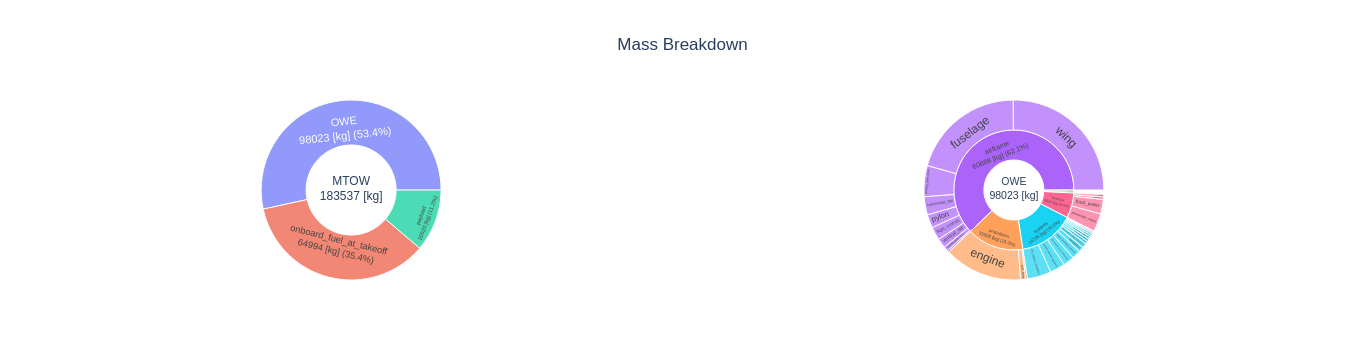

In [66]:
oad.mass_breakdown_sun_plot(MTOW_problem.output_file_path)

In [32]:
fig = oad.mass_breakdown_bar_plot(MTOW_problem.output_file_path, name="FAST-OAD")
fig.show()

In [33]:
fig = oad.wing_geometry_plot(MTOW_problem.output_file_path, name="FAST-OAD")
fig.show()

In [34]:
oad.aircraft_geometry_plot(MTOW_problem.output_file_path)

FigureWidget({
    'data': [{'mode': 'lines+markers',
              'type': 'scatter',
              'uid': '3…

You can also plot the mission profile and fuel consumption history to compare with your computations: 

In [35]:
SIZING_MISSION = pth.join(WORK_FOLDER_PATH, "oad_sizing.csv")

mission = oad.MissionViewer()
mission.add_mission(SIZING_MISSION, name="Aircraft design mission")



In [36]:
mission.display()

<div class="alert alert-block alert-danger"><b>Warning:</b> Don't forget to download your work directory on your computer.</div>

***
***

## 2. Operational Missions

Starting from your the FAST-OAD design of your aircraft you will now discover how to run a mission analysis for the an operational mission. The operationnal mission we will study is defined as follow:

- Range = A value below the desing range (For example, on the CeRAS aircraft (https://ceras.ilr.rwth-aachen.de/tiki/tiki-index.php?page=Welcome) it is around 20% of the design range)
- Diversion range = 200NM
- Payload = Payload of the design mission

For this mission the objective is to retrieve the fuel weight and consequently the take-off weight to later compare it to an other aircraft specifically design for the mission.

The new mission will be defined in another [mission file](./data/operational_mission.yml) (though it could be done in the same file as for the sizing mission since only the range will change). They are composed of a main route and a diversion and only the range will be changed in the input file.

### 2.1. Updating the configuration file 
Once you create an adapted mission file you should generate or retrieve a configuration file that would allow for a mission analysis to be run. Let's have a look to such a [file](./data/operational_mission_conf.yml): 

In [37]:
CONFIGURATION_FILE = pth.join(DATA_FOLDER_PATH, "operational_mission_conf.yml")

The [configuration file](./data/operational_mission_conf.yml) shows that high-speed aerodynamics subgroup and performances modules are called.

The option `adjust_fuel` that is set to **True** indicates that fuel weight is adjusted to the need of the mission. The take-off weight will be the results of an iterative procedure and is computed as follow: 

$ TOW = OWE + PL + BF - F_{taxi-out} - F_{TO\ run} $ with $OWE$ from the OAD sizing results, $BF$ being the block (loaded) fuel, $F_{taxi-out}$ and $F_{TO\ run}$ being respectively the consumed fuel during taxi-out and takeoff run phases. 

You need to set the option `add_solver` to **True** to allow for the iterative process to take place if no solvers are defined in the configuration file. 

Note again that the `mission_name` option must correspond to a mission described in the [mission file](./data/operational_mission.yml).

### 2.2. The input file

As indicated in the introduction of this part, you will start from the results of the OAD sizing process you have just run to compute the operational missions take-off weight and fuel consumption. 

To do so, you just have to use the XML [output file](./data/oad_sizing_out.xml) from the OAD process as the source file to generate the new input file: 

In [44]:
SOURCE_FILE = pth.join(WORK_FOLDER_PATH, "oad_sizing_out.xml")
input_file_op = oad.generate_inputs(CONFIGURATION_FILE, SOURCE_FILE, overwrite=True)

#input_file_op["data:mission:op_mission:payload"].value = 20520.0
#input_file_op["data:mission:op_mission:diversion:distance"].value = 370400
#input_file_op["data:mission:op_mission:holding:duration"].value = 1800
#input_file_op["data:mission:op_mission:main_route:range"].value = 1156*10**3*1.852
#input_file_op["data:mission:op_mission:takeoff:V2"].value = 82.3
#input_file_op["data:mission:op_mission:takeoff:altitude"].value = 458.1
#input_file_op["data:mission:op_mission:takeoff:fuel"].value = 82.4
#input_file_op["data:mission:op_mission:taxi_in:duration"].value = 600
#input_file_op["data:mission:op_mission:taxi_out:duration"].value = 300
#input_file_op["data:mission:op_mission:taxi_out:thrust_rate"].value = 0.3


INFO    : Problem inputs written in c:\Users\robbe\Documents\GitHub\Aircraft-Design-2A\B_Aircraft Sizing and Performances\workdir\operational_mission_in.xml


**Important note:** You should check carefully the mission inputs to be sure they are consistent with the mission specifications (mainly the range) and that no "nan" values are present. Don't forget to also set the correct payload.

In [39]:

oad.variable_viewer(input_file_op)

### 2.3. Operational Missions Runs

You can now run the missions analyses:

In [45]:
operational_problem = oad.evaluate_problem(CONFIGURATION_FILE, overwrite=True)

INFO    : Mission computation - iteration 0 : Using initializer computation. OTHER ITERATIONS NEEDED.
INFO    : Mission computation - iteration 1 : Using mission definition.
INFO    : Mission computation - iteration 2 : Using mission definition.
INFO    : Mission computation - iteration 3 : Using mission definition.
INFO    : Mission computation - iteration 4 : Using mission definition.
INFO    : Mission computation - iteration 5 : Using mission definition.
INFO    : Mission computation - iteration 6 : Using mission definition.
INFO    : Computation finished after 26.13 seconds
INFO    : Problem outputs written in c:\Users\robbe\Documents\GitHub\Aircraft-Design-2A\B_Aircraft Sizing and Performances\workdir\operational_mission_out.xml


The XML [output file](./workdir/operational_mission_out.xml) can be displayed in a table format using `variable_viewer`function. And you can compare the fuel consumptions and TOW with the values from the sizing mission just to see that they are indeed below the values for the sizing mission.

In [46]:
oad.variable_viewer(operational_problem.output_file_path)

You can also take a look at the mission profile:

In [47]:
OP_MISSION = pth.join(WORK_FOLDER_PATH, "operational_mission_study.csv")
SIZING_MISSION = pth.join(WORK_FOLDER_PATH, "oad_sizing.csv")

mission = oad.MissionViewer()

mission.add_mission(SIZING_MISSION, name="Aircraft design mission")
mission.add_mission(OP_MISSION, name="Aircraft operational mission")

In [48]:
mission.display()

At this point you can compute the fuel consumption, but don't forget to include to the main route the taxi out and takeoff phases. The reserves are not directly used for this computation even though they have an impact through the weight of the aircraft. 

Compare the fuel consumption per passenger and kilometer for the design mission and operationnal mission.

<div class="alert alert-block alert-danger"><b>Warning:</b> Don't forget to download your work directory on your computer.</div>

***
***

## 3. Redesign of the aircraft for the operational mission

The next part of this notebook will consist in redesigning the original aircraft so that the performance mission you selected in the second part will be the design mission and assessing the change in terms of weight and fuel consumption. For this part, we will reuse the [mission file](./data/design_mission.yml) from the first part but we will use a diffent [configuration file](./data/redesign_sizing.yml) so that we can change the name of the input and output file.

Since we used the same modules in the current configuration file than we did in the first part, the data we will need will remain the same, only their value are likely to change. Consequently, we will be able to use the input file from the first part as the source file for this third part, which is what we will do to avoid losing time. We will then be able to generate the input file based on this source file.

In [49]:
SOURCE_FILE_REDESIGN = INPUT_FILE
REDESIGN_CONFIGURATON_FILE = pth.join(DATA_FOLDER_PATH, "redesign_sizing.yml")

input_file_redesign = oad.generate_inputs(REDESIGN_CONFIGURATON_FILE, SOURCE_FILE_REDESIGN, overwrite=True)

INFO    : Problem inputs written in c:\Users\robbe\Documents\GitHub\Aircraft-Design-2A\B_Aircraft Sizing and Performances\workdir\redesign_sizing_in.xml


Don't forget to change the relevant parameter to match the redesign we want. This can be done with the Variable Viewer, but don't forget to save the file after you've made your change or the inputs from the first part will be used.

In [59]:
oad.variable_viewer(input_file_redesign)

You can now run the new problem with the following cell:

In [60]:
REDESIGN_problem = oad.evaluate_problem(REDESIGN_CONFIGURATON_FILE, overwrite=True)

INFO    : Mission computation - iteration 0 : Using initializer computation. OTHER ITERATIONS NEEDED.
INFO    : Mission computation - iteration 1 : Using mission definition.
INFO    : Mission computation - iteration 2 : Using mission definition.
INFO    : Mission computation - iteration 3 : Using mission definition.
INFO    : Mission computation - iteration 4 : Using mission definition.
INFO    : Mission computation - iteration 5 : Using mission definition.
INFO    : Mission computation - iteration 6 : Using mission definition.
INFO    : Mission computation - iteration 7 : Using mission definition.
INFO    : Mission computation - iteration 8 : Using mission definition.
INFO    : Mission computation - iteration 9 : Using mission definition.
INFO    : Mission computation - iteration 10 : Using mission definition.
INFO    : Mission computation - iteration 11 : Using mission definition.
INFO    : Mission computation - iteration 12 : Using mission definition.
INFO    : Mission computation -

NL: NLBGS Converged in 21 iterations


INFO    : Computation finished after 171.02 seconds
INFO    : Problem outputs written in c:\Users\robbe\Documents\GitHub\Aircraft-Design-2A\B_Aircraft Sizing and Performances\workdir\redesign_sizing_out.xml


The analysis of the results is left up to you. You can use the tools we presented in this notebook or in the second notebook to create plots for the report and for the comparaison of the aircrafts. We mainly expect a comparaison in the fuel consumption, the geometry of the aircraft and the mass breakdown but feel free to add any analysis that you feel like is relevant. You can use the next cell to execute your code. Don't forget that once you close your Binder session, all files are lost so regularly download the files of interest (source files, output files and this notebook if you made any change).

In [61]:
oad.variable_viewer(REDESIGN_problem.output_file_path)




Once again compare the fuel consumption per passenger and kilometer on all the mission.

<div class="alert alert-block alert-danger"><b>Warning:</b> Don't forget to download your work directory on your computer once you are done with the post-processing.</div>

You will find that the engine you put on the aircraft is oversized as the MTOW has decreased a lot during the redesign. This means that there is additional unwanted weight and this shifts the point of best sfc, which means an overestimated fuel consumption. Select new engines (mainly their T/O thrust) by justifying you choice through a quick computation or historical data. We could do multiple iteration this way, but here only one is asked.

How has the fuel consumption evolved ? What conclusion do you draw from this ? 

In [62]:
OP_MISSION = pth.join(WORK_FOLDER_PATH, "operational_mission_study.csv")
RESIZING_MISSION = pth.join(WORK_FOLDER_PATH, "oad_resizing.csv")

mission = oad.MissionViewer()
mission.add_mission(OP_MISSION, name="Aircraft operational mission")

mission.add_mission(RESIZING_MISSION, name="Aircraft redesign mission")



In [64]:
mission.display()

In [65]:
#GEOMETRIE 

OP_OUTPUT_FILE = pth.join(WORK_FOLDER_PATH, "oad_sizing_out.xml")
RES_OUTPUT_FILE = pth.join(WORK_FOLDER_PATH, "redesign_sizing_out.xml")



fig = oad.wing_geometry_plot(OP_OUTPUT_FILE, name="Aircraft operational mission")
fig = oad.wing_geometry_plot(RES_OUTPUT_FILE, name="Aircraft redesign mission", fig=fig)
fig.show()

In [66]:
fig = oad.aircraft_geometry_plot(OP_OUTPUT_FILE, name="Aircraft operational mission")
fig = oad.aircraft_geometry_plot(RES_OUTPUT_FILE, name="Aircraft redesign mission", fig=fig)
fig.show()


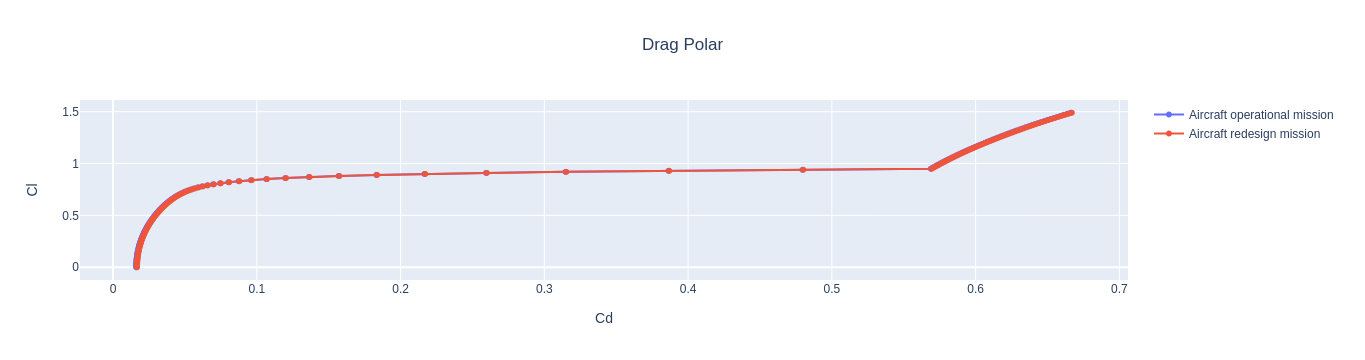

In [106]:
fig = oad.drag_polar_plot(OP_OUTPUT_FILE, name="Aircraft operational mission")
fig = oad.drag_polar_plot(RES_OUTPUT_FILE, name="Aircraft redesign mission", fig=fig)
fig.show()

In [67]:
#Masse

fig = oad.mass_breakdown_sun_plot(REDESIGN_problem.output_file_path)
#fig = oad.mass_breakdown_bar_plot(REDESIGN_problem.output_file_path, name="FAST-OAD")
fig.show()

In [68]:
fig = oad.mass_breakdown_bar_plot(OP_OUTPUT_FILE, name="Aircraft operational mission")
fig = oad.mass_breakdown_bar_plot(RES_OUTPUT_FILE, name="Aircraft redesign mission", fig=fig)
fig.show()